In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import datetime
import unicodedata
from pylab import rcParams
import os
from scipy.optimize import curve_fit
from scipy.special import zeta

In [2]:
rcParams['figure.figsize'] = 16,10
rcParams['font.size'] = 20

In [3]:
class Reaction:
    def __init__ (self, reaction_dict):
        self.actor=reaction_dict["actor"]
        self.reaction=reaction_dict["reaction"]

In [4]:
class Message:
    def __init__ (self, message_dict):
        if "content" in message_dict.keys():
            self.text=message_dict["content"]       #text of message
        else:
            self.text=""
        self.senderName=message_dict["sender_name"]      #sender's name
        self.time=datetime.datetime.fromtimestamp(message_dict["timestamp_ms"]//1000)      #time when message was sent
        self.reactions=[]
        if "reactions" in message_dict.keys():
            for reaction in message_dict["reactions"]:
                self.reactions.append(Reaction(reaction))

In [5]:
class Thread:
    def __init__ (self, allData):
        self.participants=[]
        self.messages=[]
        self.title=allData["title"]
        for participant in allData["participants"]:
            self.participants.append(participant["name"])
        for message in allData["messages"]:
            self.messages.append(Message(message))
        self.messageCount=len(self.messages)
        self.messages=sorted(self.messages,key=lambda message: message.time)
    
    def messagesUntil (self, date):
        count=0
        for message in self.messages:
            if message.time<date:
                count+=1
        return count

In [6]:
threads=[]
base = os.path.join(os.getcwd(), "messages", "inbox")
dirs = next(os.walk(base))[1]
for s in dirs:
    dir=os.path.join(base, s)
    try:
        f = open(os.path.join(dir, "message_" + str(1) + ".json"), 'r', encoding='utf8')
        s = f.read().encode().decode('raw_unicode_escape').encode('latin1').decode('utf8')
        js = json.loads(s, strict=False)
        i = 2
        while True:
            try:
                f = open(os.path.join(dir, "message_" + str(i) + ".json"), 'r', encoding='utf8')
            except:
                break
            i += 1
            s = f.read().encode().decode('raw_unicode_escape').encode('latin1').decode('utf8')
            n = json.loads(s, strict=False)
            js["messages"].extend(n["messages"])
        threads.append(Thread(js))
    except:
        continue
threads=sorted(threads, key=lambda thread: thread.messageCount, reverse=True)
del(s,n,js,f,i)

In [7]:
def printFirsts (n):
    numbers=[]
    for thread in threads:
        if thread.messageCount<20:
            break
        numbers.append(thread.messageCount)

    for index in range(n):
        print("%d. %s: %d messages" % (index+1, threads[index].title, numbers[index]))
    
    fig, ax = plt.subplots()

    plt.yscale("log")
    plt.grid(True)
    ax.plot(range(1,len(numbers)+1), numbers, "r")
    plt.xlabel("Index of thread")
    plt.ylabel("Number of messages")
    plt.title("Number of messages in each thread")
    

In [8]:
def findExtremeDates(threadList):
    firstDate=threadList[0].messages[0].time
    lastDate=threadList[0].messages[-1].time
    for thread in threadList[1:]:
        if thread.messages[0].time<firstDate:
            firstDate=thread.messages[0].time
        if thread.messages[-1].time>lastDate:
            lastDate=thread.messages[-1].time
    return firstDate,lastDate

In [9]:
def messagesTime (threadList):
    N = 1000
    firstDate, lastDate = findExtremeDates(threadList)
    totalDelta = lastDate - firstDate
    fig, ax = plt.subplots()

    for thread in threadList:
        buckets = np.zeros(N)
        for message in thread.messages:
            buckets[int((message.time - firstDate) / totalDelta * (N - 1))] += 1
        buckets = np.cumsum(buckets)
        ax.plot(buckets, label=thread.title)
    ax.legend()
    dateNames=[]
    for n in range(6):
        d=firstDate+n*totalDelta/5
        s=""
        if(d.month<10):
            s="0"
        dateNames.append(str(d.year)+"-"+s+str(d.month))
    ax.set_xticks([n*1000/5 for n in range (6)],dateNames)
    
    plt.xticks(fontsize=15, rotation = 90)
    plt.xlabel("Date")
    plt.ylabel("Number of messages (thousand)")
    plt.title("Number of messages in time")
    plt.grid(True)

In [10]:
def firstAndLastElements(listIn, topN, bottomN):
    if topN == None and bottomN==None:
        return listIn
    if topN == None:
        return listIn[-bottomN:]
    if bottomN == None:
        return listIn[:topN]
    if topN+bottomN>=len(listIn):
        return listIn
    return listIn[:topN]+ listIn[-bottomN:]

In [11]:
def senderStats (threadList, topN=None, bottomN=None):
    statsPerSender = {}

    for thread in threadList:
        for message in thread.messages:
                emojis = 0 #emoji.emoji_count(m['content'])
                words = len(message.text.split())
                letters = len(message.text) - emojis - words + 1
                if message.senderName in statsPerSender:
                    statsPerSender[message.senderName]['letter_count'] += letters
                    statsPerSender[message.senderName]['emoji_count'] += emojis
                    statsPerSender[message.senderName]['word_count'] += words
                    statsPerSender[message.senderName]['message_count'] += 1
                else:
                    statsPerSender[message.senderName] = {'letter_count': letters, 'emoji_count': emojis, 'word_count': words, 'message_count': 1}

    for s in statsPerSender:
        statsPerSender[s]['avg_word_len'] =    round(statsPerSender[s]['letter_count'] / statsPerSender[s]['word_count'], 1)
        statsPerSender[s]['avg_message_len'] = round(statsPerSender[s]['letter_count'] / statsPerSender[s]['message_count'], 1)

    print("Number of characters")
    for s in firstAndLastElements(sorted(statsPerSender.keys(), key=lambda x: statsPerSender[x]['letter_count'], reverse=True), topN, bottomN):
        print(s, ": ", statsPerSender[s]['letter_count'])

    #print("\nEmojik száma")
    #for s in firstAndLastElements(sorted(statsPerSender.keys(), key=lambda x: statsPerSender[x]['emoji_count'], reverse=True), topN, bottomN):
    #    print(s, ": ", statsPerSender[s]['emoji_count'])

    print("\nNumber of words")
    for s in firstAndLastElements(sorted(statsPerSender.keys(), key=lambda x: statsPerSender[x]['word_count'], reverse=True), topN, bottomN):
        print(s, ": ", statsPerSender[s]['word_count'])

    print("\nAverage length of words")
    for s in firstAndLastElements(sorted(statsPerSender.keys(), key=lambda x: statsPerSender[x]['avg_word_len'], reverse=True), topN, bottomN):
        print(s, ": ", statsPerSender[s]['avg_word_len'], " characters")

    print("\nÁtlagos üzenethossz karakterben")
    for s in firstAndLastElements(sorted(statsPerSender.keys(), key=lambda x: statsPerSender[x]['avg_message_len'], reverse=True), topN, bottomN):
        print(s, ": ", statsPerSender[s]['avg_message_len'])
    print("\n")

In [12]:
def messagesTimeOfDay(threadList):
    quarters = np.zeros(24 * 4)

    for thread in threadList:
        for message in thread.messages:
            index = message.time.hour * 4 + message.time.minute // 15
            quarters[index] += 1

    kernel = np.array([0.09672046549155401, 0.24044903390287659, 0.3256610012111388, 0.24044903390287659, 0.09672046549155401])
    r = kernel.size // 2
    smoothed = np.zeros(24 * 4)
    for i in range(24 * 4):
        s = 0
        for j in range(-r, r + 1):
            s += kernel[j + r] * quarters[(i + j) % (24 * 4)]
        smoothed[i] = s / 15
            
    x = [i / 4 for i in range(24 * 4 + 1)]
    fig, ax = plt.subplots()
    ax.plot(x, smoothed.tolist() + [smoothed[0]],"r")

    plt.xlabel("Hours of the day")
    plt.ylabel("Message count")
    plt.title("Frequency of messages within a day")
    plt.xticks([0,4,8,12,16,20,24])

    plt.xlim(0, 24.00)
    plt.grid(True)

In [13]:
def standardizeTexts(threadList):
    standardTexts = []
    for thread in threadList:
        for message in thread.messages:
            if message.text != "":
                message2 = message
                text = message.text
                message2.text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').lower().decode("utf-8") 
                standardTexts.append(message2)
    return standardTexts

In [14]:
def searchCount(standardTexts, key):
    key = unicodedata.normalize('NFD', key).encode('ascii', 'ignore').lower().decode("utf-8") 
    result = dict()
    for message in standardTexts:
        c = message.text.count(key)
        if (message.senderName in result):
            result[message.senderName]['count'] += c
        else:
            result[message.senderName] = {'count': c}

    return result

In [15]:
def wordNumber (threadList, key, topN=None):
    standardTexts = standardizeTexts(threadList)
    hits = searchCount(standardTexts, key)

    print("Number of occurances of \"" + str(key) + "\"")
    for s in firstAndLastElements(sorted(hits.keys(), key=lambda x: hits[x]['count'], reverse=True),topN,None):
        print(s, ": ", hits[s]['count'])
    print("\n")

In [16]:
def getWordCounts(threadList, separate):
    wordCounts = dict()
    standardTexts=standardizeTexts(threadList)

    for message in standardTexts:
        words = message.text.split()
        sender=message.senderName
        if(not separate):
            sender="Sum of all users"
        for word in words:
            if (sender in wordCounts.keys()):
                if (word in wordCounts[sender].keys()):
                    wordCounts[sender][word] += 1
                else:
                    wordCounts[sender][word] = 1
            else:
                wordCounts[sender] = {word: 1}
    return wordCounts

In [17]:
def harmonicNumber (s, N):
    return sum([1/k**s for k in range(1,N+1)])

In [18]:
def mostUsedWords(threadList, separate=False, first=0, last=11, ZipfPlot=True):
    wordCounts=getWordCounts(threadList, separate)
    print("Most used words:")
    for sender in wordCounts.keys():
        print(sender)
        for word in sorted(wordCounts[sender], key=wordCounts[sender].get, reverse=True)[first:last]:
            print(word, ":", wordCounts[sender][word])
        print()
    
    if(not ZipfPlot):
        return
    
    if(separate):
        print("to recieve distribution plot, set separate=False")
        return
    
    numbers=[]
    for word in sorted(wordCounts["Sum of all users"], key=wordCounts["Sum of all users"].get, reverse=True):
        if(wordCounts["Sum of all users"][word]<5):
            break
        numbers.append(wordCounts["Sum of all users"][word])
    area=np.trapz(numbers)
    numbers=numbers/area
    N=len(numbers)
    
    H_N=harmonicNumber(1,N)
    Zipf=[1/k/H_N for k in range(1,N+1)]

    fig, ax=plt.subplots()
    plt.yscale("log")
    plt.xscale("log")
    plt.grid(True)
    ax.plot(range(1,N+1), numbers, "r", label="distribution of words")
    ax.plot(range(1,N+1), Zipf, "k", label="Zipf distribution with (s=1)")

    plt.legend()
    plt.xlabel("Index of word")
    plt.ylabel("relative number of occurances")
    plt.title("Zipf's law in action")

In [19]:
def timeElapsed(resp, threadList):
    
    responseTimes=[]

    for thread in threadList:
        lastSender=thread.messages[0].senderName
        lastTime=thread.messages[0].time
        for message in thread.messages:
            if (lastSender!=resp and message.senderName==resp):
                responseTimes.append((message.time-lastTime).total_seconds())
            lastSender=message.senderName
            lastTime=message.time
    return responseTimes

In [20]:
def histplot(responseTimes, responder, ax):
    counts,bins= np.histogram(responseTimes, bins=30, range=(0,300))
    portion=sum(counts)*100/len(responseTimes)
    print("%.1f%% of %s's answers come within 5 minutes" % (portion, responder))

    counts2,bins2 = np.histogram(responseTimes, bins=30, range=(0,60))
    portion2=sum(counts2)*100/len(responseTimes)
    print("%.1f%% of %s's answers come within 1 minutes" % (portion2, responder))
    
    respo2=[x if x<=300 else 320 for x in responseTimes]
    ax.hist(respo2, 100, range=(0,320), density=True, histtype='step',cumulative=True, label="responses of %s" % responder)

In [21]:
def getParticipants (threadList):
    participants=set([])
    for thread in threadList:
        participants = participants | set(thread.participants)
    return participants

In [22]:
def responseTime(threadList):
    fig, ax = plt.subplots()
    for responder in getParticipants(threadList):
        responseTimes=timeElapsed(responder, threadList)
        histplot(responseTimes, responder, ax)


    plt.title("Cumulative distribution function of response times")
    plt.xlabel("Response time (sec)")
    plt.ylabel("Portion of responses")
    plt.xlim(0,300)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [23]:
def testCases():
    printFirsts(5)
    messagesTime(threads[:10])
    senderStats([threads[0]], topN=1)
    messagesTimeOfDay(threads)
    wordNumber([threads[1]], "egyenlore")
    wordNumber(threads[:1], "egyenlore", topN=1)
    mostUsedWords(threads, separate=False)
    mostUsedWords([threads[1]], separate=True, ZipfPlot=False)
    responseTime([threads[1]])

1. Osztálycsoport ( 2021C ): 80577 messages
2. Balázs Bonifert: 72585 messages
3. Levente Sohár: 48977 messages
4. Diep Bich Nguyen: 45390 messages
5. Horváth Anikó: 34413 messages
Number of characters
Halasi Tamás :  220438

Number of words
Halasi Tamás :  41431

Average length of words
Dávid Bukva :  12.2  characters

Átlagos üzenethossz karakterben
Győri Krisztina Boróka :  63.2


Number of occurances of "egyenlore"
Balázs Bonifert :  30
Ábel Tóth :  4


Number of occurances of "egyenlore"
Halasi Tamás :  1


Most used words:
Sum of all users
a : 113202
nem : 69825
az : 65238
es : 39018
de : 38381
meg : 35393
hogy : 32564
is : 30561
akkor : 22694
egy : 21091
csak : 20316

Most used words:
Ábel Tóth
a : 9949
az : 7190
nem : 6327
meg : 3761
de : 3750
hogy : 3584
es : 3330
is : 3179
akkor : 2675
csak : 2028
van : 1822

Balázs Bonifert
a : 11215
az : 6922
nem : 6450
h : 4889
es : 3558
meg : 2825
de : 2405
is : 2295
akkor : 2254
van : 2124
ha : 1867

94.1% of Balázs Bonifert's answers co

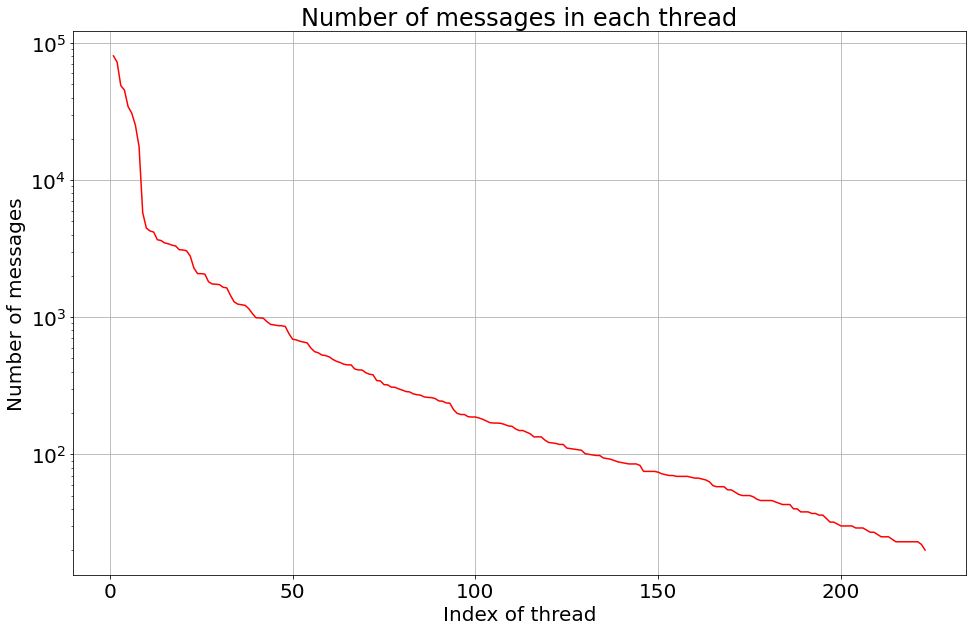

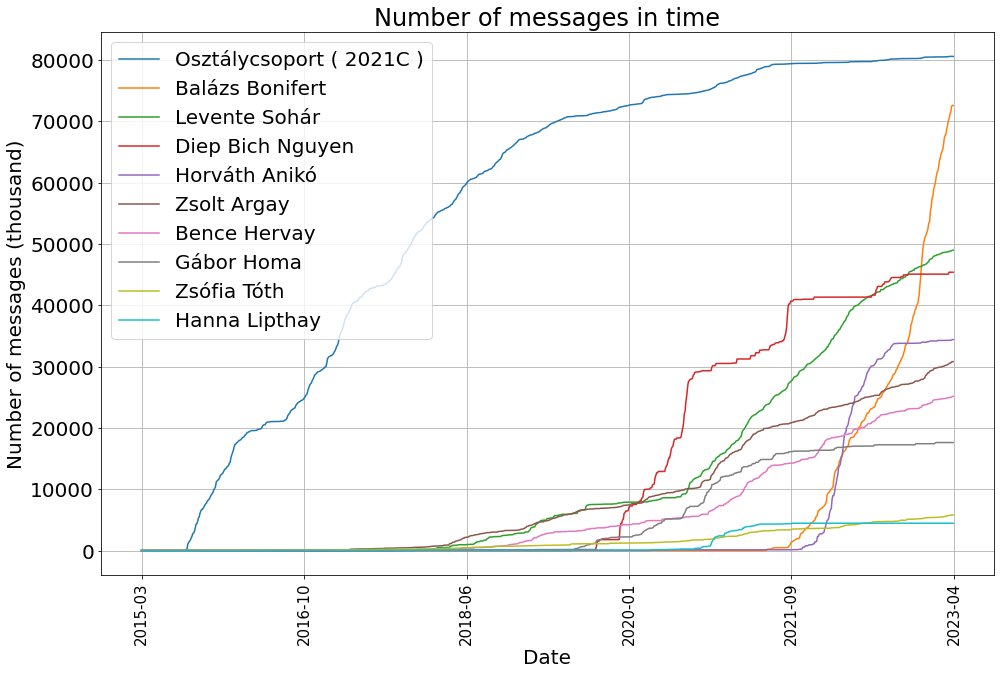

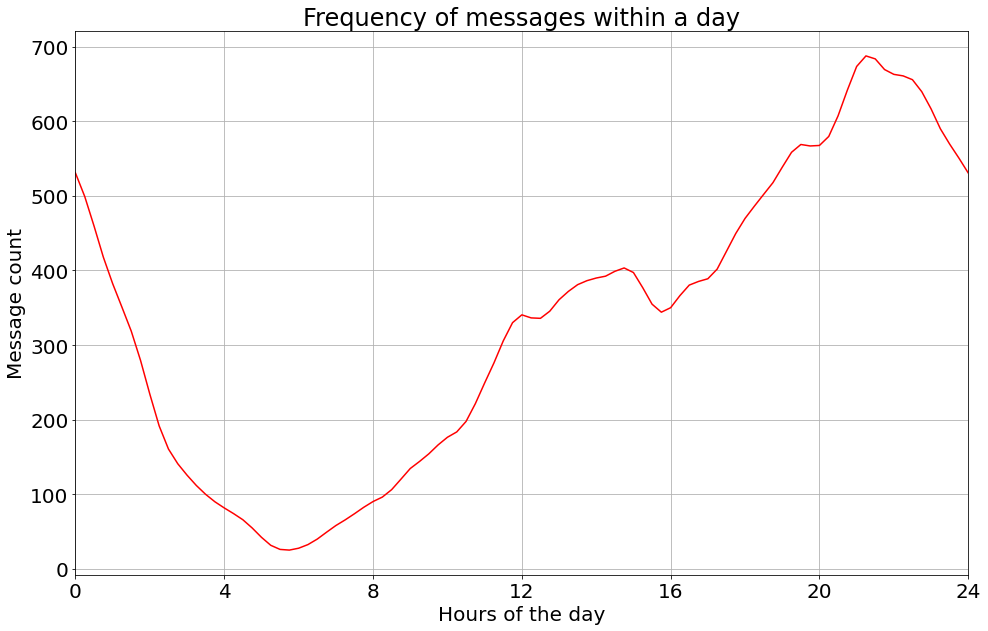

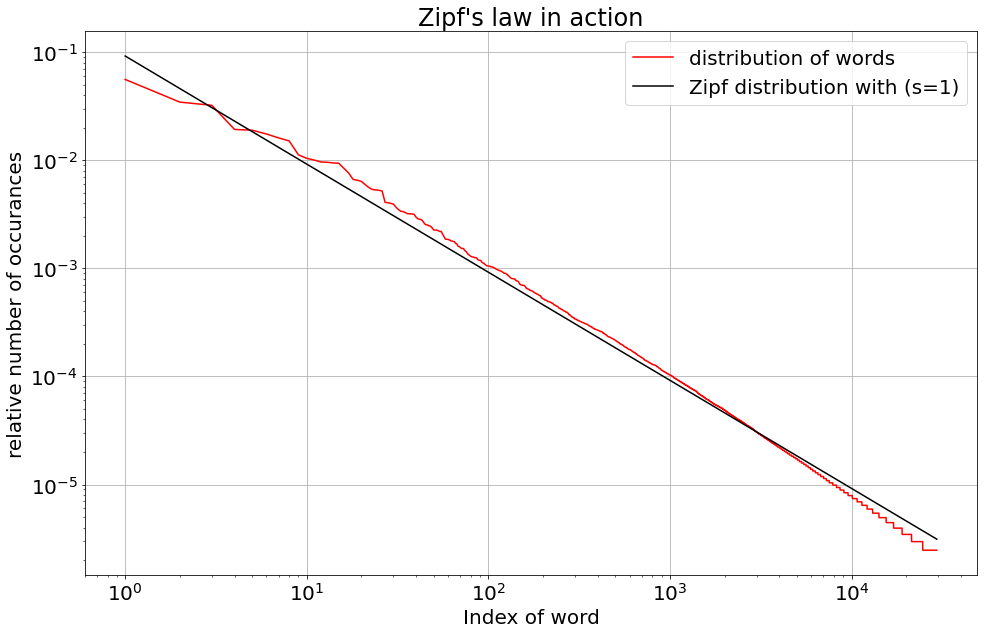

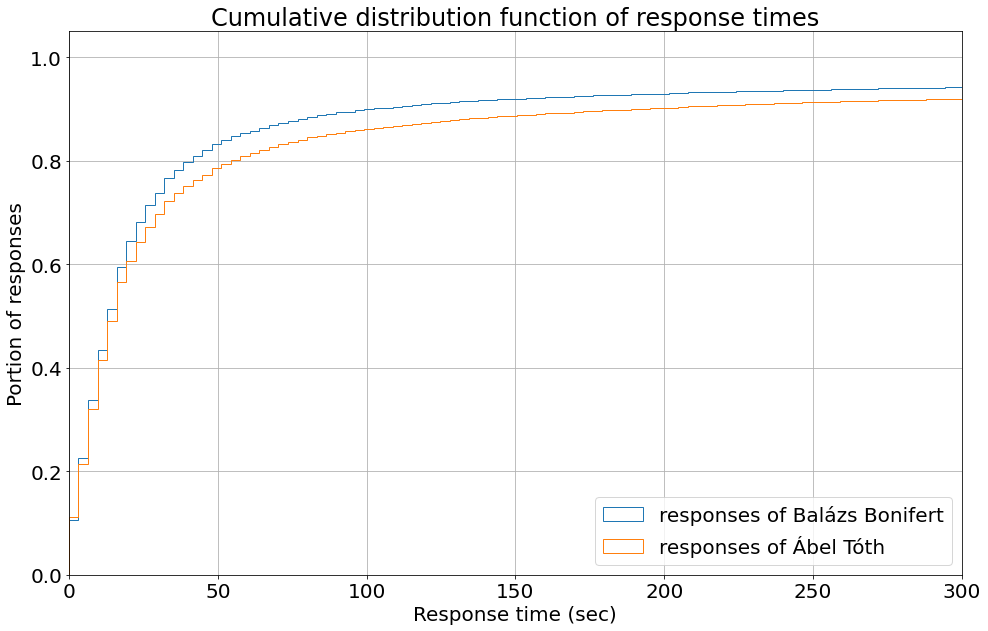

In [24]:
testCases()